## Customer Segmentation
We will be using E-commerce dataset of user purchases and try develop a model that allow us to do two things:
- Classifying customers into segments.
- Anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase by assigning them appropriate cluster/segment

## Import packages

In [1]:
# from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## Data Preparation

In [3]:
# df_initial = pd.read_csv('https://raw.githubusercontent.com/firmai/python-business-analytics/master/data/customer/data.csv',encoding="ISO-8859-1",
#                          dtype={'CustomerID': str,'InvoiceID': str})
df_initial = pd.read_csv('/Users/hongyingyue/Git/python-business-analytics/data/customer/data.csv',encoding="ISO-8859-1")
print('Dataframe dimensions:', df_initial.shape)
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

Dataframe dimensions: (284709, 8)


In [4]:
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,559518,21989,PACK OF 20 SKULL PAPER NAPKINS,6,2011-07-08 16:11:00,1.63,NaN,United Kingdom
1,559518,22055,MINI CAKE STAND HANGING STRAWBERY,1,2011-07-08 16:11:00,3.29,NaN,United Kingdom
2,559518,22179,SET 10 NIGHT OWL LIGHTS,1,2011-07-08 16:11:00,13.29,NaN,United Kingdom
3,559518,22297,HEART IVORY TRELLIS SMALL,1,2011-07-08 16:11:00,2.46,NaN,United Kingdom
4,559518,22352,LUNCH BOX WITH CUTLERY RETROSPOT,1,2011-07-08 16:11:00,4.96,NaN,United Kingdom


## EDA

### Identify null values

In [6]:
# gives some infomation on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100,2)).T.
                         rename(index={0:'null values (%)'}))
print ('-' * 10 + " Display information about column types and number of null values " + '-' * 10 )
print 
display(tab_info)

---------- Display information about column types and number of null values ----------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,502,0,0,0,61357,0
null values (%),0.0,0.0,0.18,0.0,0.0,0.0,21.55,0.0


Note:
- If you are looking to the CustomerID column then there are  ∼ 25% data entries are null.
- That means there are  ∼ 25% of data entries which aren't assigned to any customer(s).
- It is impossible for us to map values for the customer and these entries. These are usless for the current exercise.

Because of all the above points we are deleting these data entries.

### Remove data entries

In [8]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
# gives some information on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100,2)).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (223352, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
print('Duplicate data entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate data entries: 3175


## Explore data attributes

### Country

In [10]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(
    ['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('No. of cuntries in dataframe: {}'.format(len(countries)))

No. of cuntries in dataframe: 32


In [14]:
temp_no_of_order_per_count = df_initial[['CustomerID','Country']].groupby(['Country']).count()
temp_no_of_order_per_count = temp_no_of_order_per_count.reset_index(drop = False)

print('-' * 10 + " Contry-wise order calculation "+ '-' * 10)
print
print (temp_no_of_order_per_count.sort_values(
    by='CustomerID', ascending=False).rename(index=str,
                                        columns={"CustomerID": "Country wise number of order"}))

---------- Contry-wise order calculation ----------
                 Country  Country wise number of order
30        United Kingdom                        195468
12               Germany                          5020
11                France                          4633
8                   EIRE                          4592
25                 Spain                          1326
19           Netherlands                          1126
27           Switzerland                          1095
2                Belgium                          1072
22              Portugal                           847
20                Norway                           708
0              Australia                           587
16                 Italy                           491
4        Channel Islands                           389
10               Finland                           363
1                Austria                           274
28                   USA                           269
5            

### Customers and Products

In [15]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], 
              index = ['quantity'])

,products,transactions,customers
quantity,3182,11068,3341


In [16]:
# to explore the number of products purchased in every transaction
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12347.0,562032,22
1,12347.0,573511,47
2,12347.0,581180,11
3,12348.0,568172,3
4,12349.0,577609,73
5,12352.0,567505,18
6,12352.0,568699,14
7,12352.0,574275,15
8,12356.0,576895,2
9,12357.0,574740,131


In [19]:
nb_products_per_basket[nb_products_per_basket['Number of products']==1].head(3)

,CustomerID,InvoiceNo,Number of products
33,12371.0,572770,1
38,12375.0,C581071,1
44,12380.0,C572532,1


Points to be noted here:
- There are some users who only came one time on the E-commerce platform and purchased one item. The example of this kind of user is customerID 12371.
- There are some users who frequently buy large number of items per order. The example of this kind of user is customerID 12357.
- If you notice InvoiceNo data attribute then you can find out that there is prefix 'C' for one invoice. This 'C' indicates that the particular transaction has been cancelled.

### Cancelled orders
We need to count the number of transactions corresponding to cancelled orders

In [23]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(
    lambda x:int('C' in x))
display(nb_products_per_basket[38:45])

n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
percentage = (n1/n2)*100
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, percentage))

,CustomerID,InvoiceNo,Number of products,order_cancelled
38,12375.0,C581071,1,1
39,12378.0,562046,219,0
40,12379.0,567196,20,0
41,12380.0,567928,28,0
42,12380.0,571187,23,0
43,12380.0,577180,17,0
44,12380.0,C572532,1,1


Number of orders cancelled: 1686/11068 (15.23%) 


In [25]:
# to check if there is systematically an order indicating the same quantity (but positive), 
# with the same description (CustomerID, Description and UnitPrice)
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID                         14808.0
Quantity                                -1
StockCode                            22655
Description    VINTAGE RED KITCHEN CABINET
UnitPrice                            125.0
Name: 279, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [26]:
# because of the existence of a 'Discount' entry
# to check again the hypothesis but this time discarding the 'Discount' entries
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

279 CustomerID                         14808.0
Quantity                                -1
StockCode                            22655
Description    VINTAGE RED KITCHEN CABINET
UnitPrice                            125.0
Name: 279, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, the initial hypothesis is not verified. 
Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

In [27]:
# to create a new variable in the dataframe that indicate if part of the command has been canceled
# For the cancellations without counterparts, a few of them are probably due to the fact that 
# the buy orders were performed before December 2010 (the point of entry of the database). 
# Below, to make a census of the cancel orders and check for the existence of counterparts:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
   
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
   
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above function, I checked the two cases:
- a cancel order exists without counterpart
- there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [28]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 3424
doubtfull_entry: 984


In [43]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries

nb of entries to delete: 10


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
76464,C566209,23355,HOT WATER BOTTLE KEEP CALM,-5,2011-09-09 15:04:00,4.95,16362.0,United Kingdom,0
80564,C566467,22384,LUNCH BAG PINK POLKADOT,-14,2011-09-12 18:04:00,1.65,14688.0,United Kingdom,0
103337,C568232,23007,SPACEBOY BABY GIFT SET,-3,2011-09-26 11:27:00,16.95,14808.0,United Kingdom,0
165413,C573097,23251,VINTAGE RED ENAMEL TRIM MUG,-18,2011-10-27 14:42:00,1.25,15038.0,United Kingdom,0
177723,C574065,22945,CHRISTMAS METAL TAGS ASSORTED,-24,2011-11-02 14:43:00,0.85,13271.0,United Kingdom,0
183052,C574524,22947,WOODEN ADVENT CALENDAR RED,-2,2011-11-04 13:53:00,7.95,17841.0,United Kingdom,0
259575,C579948,21098,CHRISTMAS TOILET ROLL,-3,2011-12-01 10:56:00,1.25,16376.0,United Kingdom,0
262933,C580263,M,Manual,-4,2011-12-02 12:43:00,9.95,12536.0,France,0
262934,C580263,M,Manual,-16,2011-12-02 12:43:00,0.29,12536.0,France,0
270155,C580708,84946,ANTIQUE SILVER T-LIGHT GLASS,-12,2011-12-05 16:33:00,1.25,14546.0,United Kingdom,0


### StockCode

In [44]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['M', 'POST', 'D', 'C2', 'PADS', 'DOT', 'BANK CHARGES'],
      dtype=object)

In [45]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

M               -> Manual                        
POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
BANK CHARGES    -> Bank Charges                  


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

### Basket Price

In [46]:
# to create a new variable that indicates the total price of every purchase
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
171803,573511,22131,FOOD CONTAINER SET 3 LOVE HEART,6,2011-10-31 12:25:00,1.95,12347.0,Iceland,0,11.7
171761,573511,22375,AIRLINE BAG VINTAGE JET SET BROWN,8,2011-10-31 12:25:00,4.25,12347.0,Iceland,0,34.0
171762,573511,22371,AIRLINE BAG VINTAGE TOKYO 78,12,2011-10-31 12:25:00,3.95,12347.0,Iceland,0,47.4
171763,573511,22374,AIRLINE BAG VINTAGE JET SET RED,8,2011-10-31 12:25:00,4.25,12347.0,Iceland,0,34.0
171764,573511,22252,BIRDCAGE DECORATION TEALIGHT HOLDER,12,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,15.0


In [48]:
# to ollect all the purchases made during a single order to recover the total order price

# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12347.0,562032,584.91,2011-08-02 08:48:00
1,12347.0,573511,1294.32,2011-10-31 12:25:00
2,12347.0,581180,224.82,2011-12-07 15:52:00
3,12348.0,568172,310.00,2011-09-25 13:13:00
4,12349.0,577609,1757.55,2011-11-21 09:51:00
5,12352.0,567505,366.25,2011-09-20 14:34:00


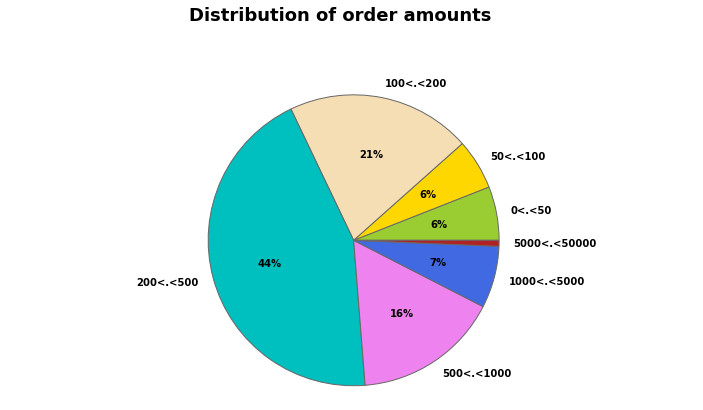

In [49]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);